### Notebooks : Latitudes and longitudes covered by the drifters over a time period
#### Goals : Estimate the distance (in x and y) covered by drifters over a time period and how this could impact the other diags that have been previously computed (correlation, energy spectra).
#### References : No references for now

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima
import matplotlib as mpl

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [4]:
client

Client Scheduler: tcp://10.148.1.70:56758 Dashboard: http://10.148.1.70:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


In [5]:
root_path = '/home/c11-data/Test_aponte/jetn/old/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
dr = cdr.drifter_dataframe(root_path+run, tdir_max=1)

In [7]:
# Definition parameters
t0 = 1550 #initial time
t1 = 1590 # final time
tmid = (t0+t1)/2 # mid period
flt_id = 225 # test drifter id

#### Functions to compute initial, final, maximal and minimal latitudes for each drifters over a period of time

In [8]:
def diags_dist(v1,v2,v3,v4,N):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if v1 is None and v2 is None:
        return pd.Series(np.random.randn(N),index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])
    else : 
        dxint = np.abs(v3).sum()#np.diff(np.unwrap(v1)).sum()
        dyint = np.abs(v4).sum()#np.diff(v2).sum()
        dsint = np.sqrt(v3**2+v4**2).sum()#np.diff(np.unwrap(v1))**2+np.diff(v2)**2).sum()
        return pd.Series([np.unwrap(v1).max(),np.unwrap(v1).min(),v2.max(),v2.min(),v2.iloc[0],v2.iloc[-1],dxint,dyint,dsint],
                         index=['xmax','xmin','ymax','ymin','y0','y1','dx','dy','ds'])#,fltI.v

#### test the function for one drifter (flt_id)

In [9]:
df0 = dr.df.groupby('id').get_group(flt_id).compute()

In [14]:
#out = latitudes_processing(df0, diags_dist, t0,t1)
L=1026
out = cdr.time_window_processing(df0, diags_dist,['x','y','u','v'],80,9,L)
out

,x,y,id,xmax,xmin,ymax,ymin,y0,y1,dx,dy,ds
1540.0069,53.630371,1961.574268,225.0,310.30892,-111.73086,2041.41528,1857.4214,1950.46532,1857.4214,1512.709566,1527.320701,2404.398374


#### Apply the function to each drifter : 

In [10]:
def apply_window(myfun,columns,T,N,L,binsize):
    """Compute diags_dist and returns xarray"""
    df_chunked = dr.df.groupby('id').apply(cdr.time_window_processing, diags_dist, 
                                       columns,T,N,L
                                      )
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y0_cut'] = df_chunked['y0'].map_partitions(pd.cut, bins=y_bins)
    df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
    # difference btw y max and min
    df_chunked['ydiff'] = df_chunked['ymax']-df_chunked['ymin']
    # difference btw x max and min
    df_chunked['xdiff'] = df_chunked['xmax']-df_chunked['xmin']
    DF = df_chunked.compute()
    return DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()

In [11]:
L = 1026
ds40 = apply_window(diags_dist,['x','y','u','v'],40,9,L,50)
ds20 = apply_window(diags_dist,['x','y','u','v'],20,9,L,50)
ds80 = apply_window(diags_dist,['x','y','u','v'],80,9,L,50)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from parti

In [12]:
ds40_stats = ds40.groupby('y0_cut').mean().persist()
ds20_stats = ds20.groupby('y0_cut').mean().persist()
ds80_stats = ds80.groupby('y0_cut').mean().persist()

#### Difference beteween x and y extrema for each drifter over T=20,40,80 days time windows

Text(0, 0.5, '$y_{max}-y_{min}$')

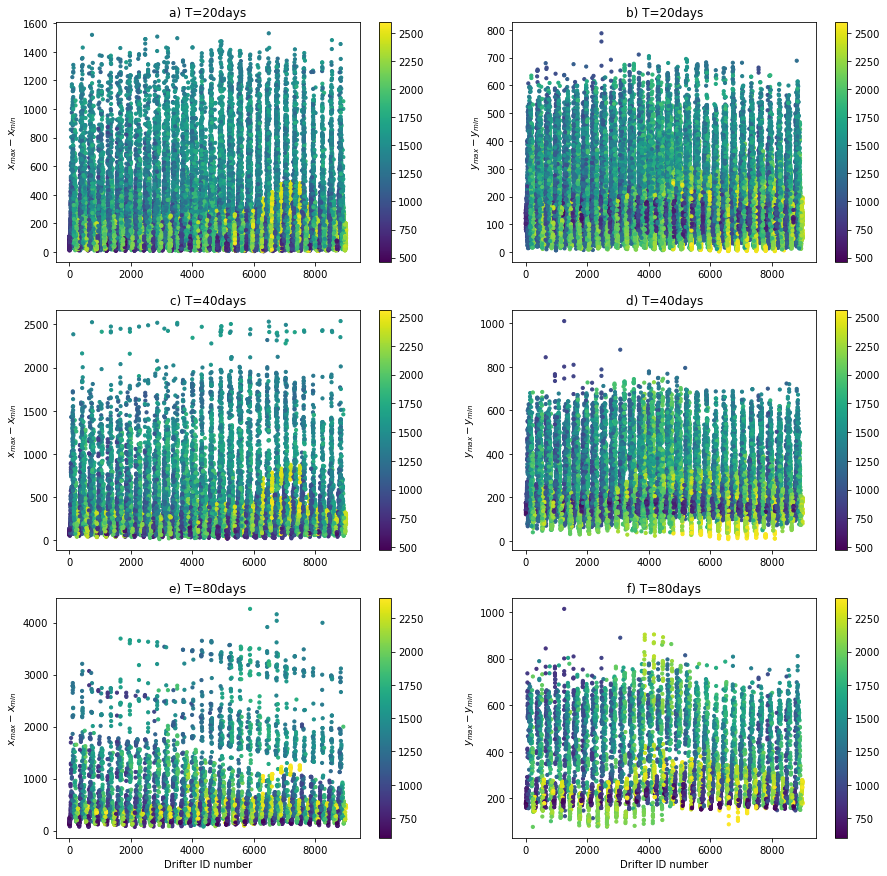

In [18]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,2,1)
cs = xr.plot.scatter(ds20,'id','xdiff',s=10,c=ds20.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('a) T=20days')
ax.set_xlabel('');ax.set_ylabel(r'$x_{max}-x_{min}$')
ax = fig.add_subplot(3,2,2)
cs = xr.plot.scatter(ds20,'id','ydiff',s=10,c=ds20.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('b) T=20days')
ax.set_xlabel('');ax.set_ylabel(r'$y_{max}-y_{min}$')
ax = fig.add_subplot(3,2,3)
cs = xr.plot.scatter(ds40,'id','xdiff',s=10,c=ds40.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('c) T=40days')
ax.set_xlabel('');ax.set_ylabel(r'$x_{max}-x_{min}$')
ax = fig.add_subplot(3,2,4)
cs = xr.plot.scatter(ds40,'id','ydiff',s=10,c=ds40.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('d) T=40days')
ax.set_xlabel('');ax.set_ylabel(r'$y_{max}-y_{min}$')
ax = fig.add_subplot(3,2,5)
cs = xr.plot.scatter(ds80,'id','xdiff',s=10,c=ds80.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('e) T=80days')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$x_{max}-x_{min}$')
ax = fig.add_subplot(3,2,6)
cs = xr.plot.scatter(ds80,'id','ydiff',s=10,c=ds80.y0,ax=ax)
plt.colorbar(cs)
ax.set_title('f) T=80days')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$y_{max}-y_{min}$')

#### Comments : 
c) We observe the values closer to 1.(within the [0.8;1.2] range) to correspond to low (<1000km) or high (>2000km) initial latitudes.The values lower than 1 seem to correspond mainly low initial latitudes. Those obsevations are coherent with the previous observations.\
d) We find that during this time period the drifter can move a lot between their maximum and minimum latitudes depending on their initial latitude.\
At low initial latitudes (<1000km), the difference btw latmax and latmin stays around 150 km.\
At high latitudes (>2000km), we find more differences with diff from 0 to $\sim$200km for lat0>2400km and larger differences ($\sim$400km) for some drifters nearer of 2000km.\
Between 1000 and 2000 km the difference range from near 0 to over 600km.

#### Averaging over initial bins

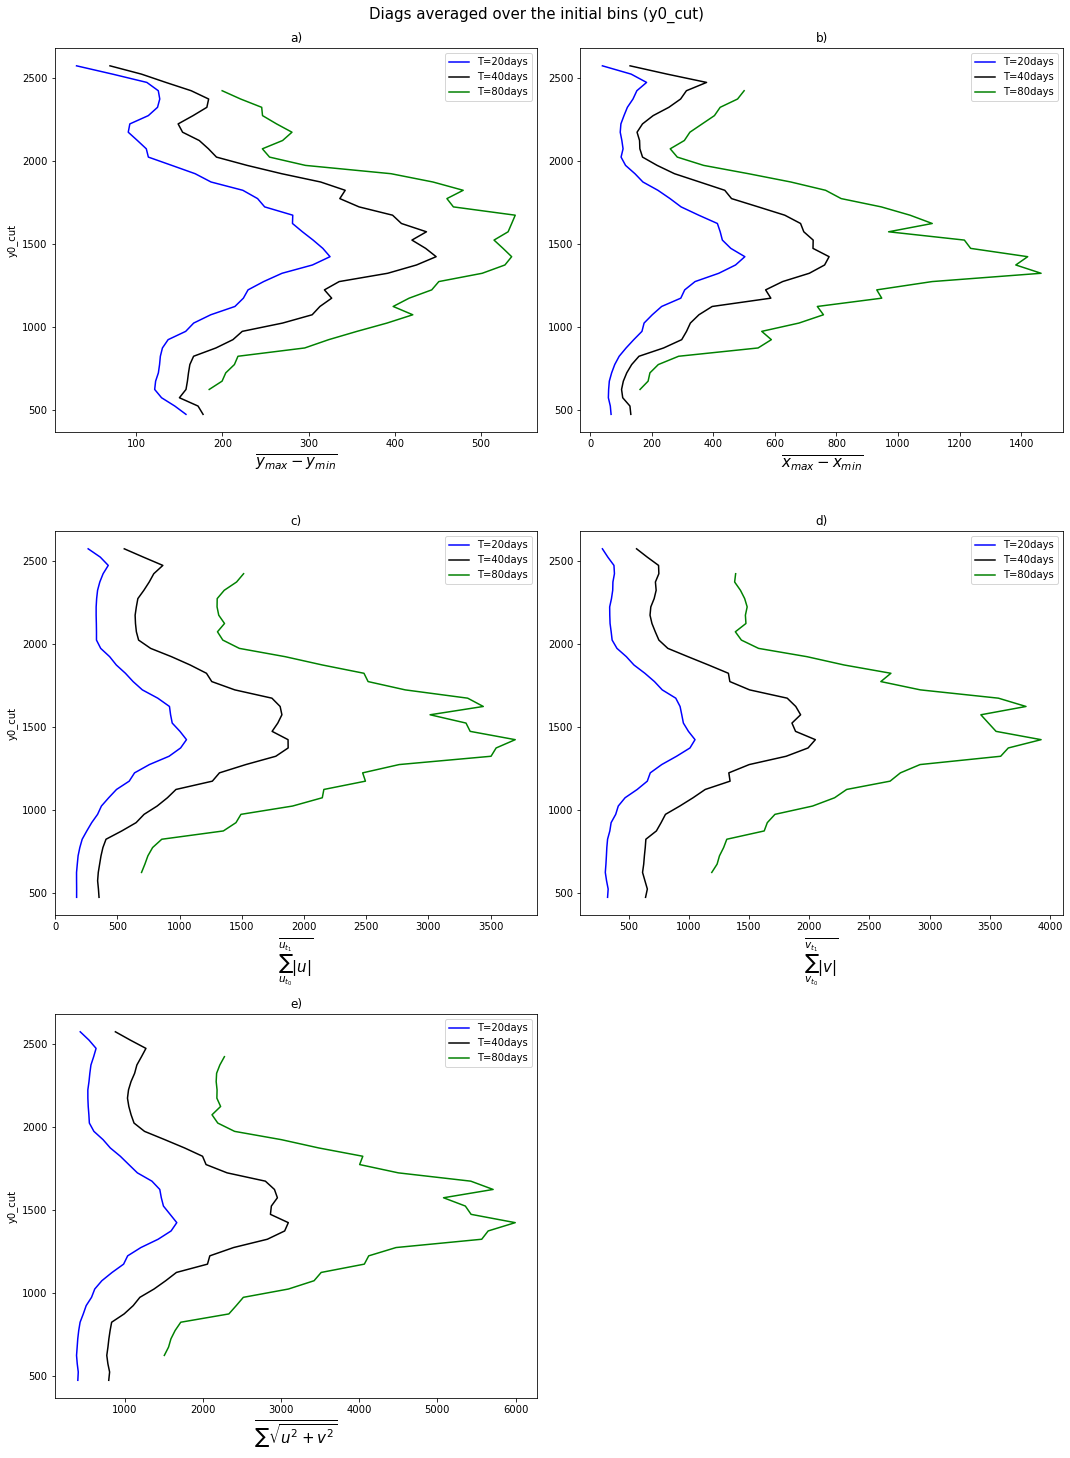

In [35]:
fontsize = 15
fig = plt.figure(figsize=(15,20))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=fontsize)
ax = fig.add_subplot(3,2,1)
ds20_stats.ydiff.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.ydiff.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.ydiff.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{y_{max}-y_{min}}$',fontsize=fontsize)
ax.set_title('a)')
plt.legend()
ax = fig.add_subplot(3,2,2)
ds20_stats.xdiff.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.xdiff.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.xdiff.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{x_{max}-x_{min}}$',fontsize=fontsize);ax.set_ylabel('')
ax.set_title('b)')
plt.legend()
ax = fig.add_subplot(3,2,3)
ds20_stats.dx.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.dx.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.dx.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{\sum_{u_{t_0}}^{u_{t_1}}|u|}$',fontsize=fontsize)
ax.set_title('c)')
plt.legend()
ax = fig.add_subplot(3,2,4)
ds20_stats.dy.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.dy.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.dy.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{\sum_{v_{t_0}}^{v_{t_1}}|v|}$',fontsize=fontsize);ax.set_ylabel('')
ax.set_title('d)')
plt.legend()
ax = fig.add_subplot(3,2,5)
ds20_stats.ds.plot(y='y0_cut',ax=ax,c='b',label='T=20days')
ds40_stats.ds.plot(y='y0_cut',ax=ax,c='k',label='T=40days')
ds80_stats.ds.plot(y='y0_cut',ax=ax,c='g',label='T=80days')
ax.set_xlabel(r'$\overline{\sum \sqrt{u^2+v^2}}$',fontsize=fontsize)
ax.set_title('e)')
plt.tight_layout()
plt.legend()

In [32]:
print(ds20_stats.ydiff,ds80_stats.ydiff)

<xarray.DataArray 'ydiff' (y0_cut: 43)>
array([157.72157419, 144.76113135, 129.40676292, 121.43123436,
       122.51826382, 125.72199738, 127.09588447, 128.01979372,
       130.42786987, 137.01492723, 157.41436569, 166.67678758,
       186.46371978, 214.5210001 , 224.33126825, 229.73033316,
       247.8373447 , 269.18246581, 304.45166993, 324.85152373,
       316.50947591, 305.21159588, 292.82819031, 281.2839918 ,
       281.60979949, 249.02861232, 240.79905039, 223.69977258,
       186.80983214, 168.35358648, 141.34160012, 114.10681312,
       111.70946582, 101.38675819,  90.76593457,  92.60550447,
       114.0694218 , 124.73826142, 127.32857739, 125.61876638,
       112.34741818,  72.56758146,  30.78529923])
Coordinates:
  * y0_cut   (y0_cut) float64 475.0 525.0 575.0 ... 2.525e+03 2.575e+03 <xarray.DataArray 'ydiff' (y0_cut: 37)>
array([184.68729916, 199.61438607, 203.88676454, 213.91488333,
       218.05098172, 295.48635373, 323.31472898, 356.09551255,
       390.92336932, 420.8501

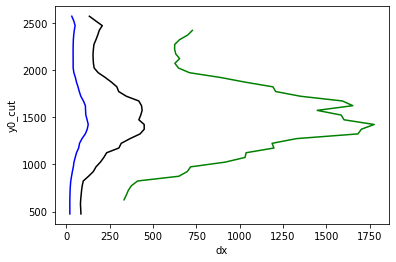

In [20]:
fig,ax = plt.subplots()
((20*24*3600)*ds20_stats.dx/14400000).plot(y='y0_cut',ax=ax,c='b',label='T=20days')
((40*24*3600)*ds40_stats.dx/14400000).plot(y='y0_cut',ax=ax,c='k',label='T=40days')
((80*24*3600)*ds80_stats.dx/14400000).plot(y='y0_cut',ax=ax,c='g',label='T=80days')
plt.show()

### Comments:
a) The largest difference (>450km) between maximal and minimal latitudes are found in initial bins in the jet ; smaller differencies being found far south (<1000km) and north (>2000km) from the jet.\
b) Slight northward tendency (lat1>lat0) for low and mid latitudes ($\sim$<1600km). Southward tendency for higher latitudes with a peak around 1900km (lat1$\simeq$1.075lat0). Overall, the ratio lat0/lat1 stays within the range [0.950 ; 1.075]\
c) Large distance covered in the jet in the x axis (this was expected). The motion is eastward which is also expected (the contrary would have been quite disturbing)\
d) Southward tendency north of the jet and northward tendency south of the jet (this is quite logicial because of the northern and southern boundaries). Near the northern boundary of the jet drifter seem attracted southward (toward the jet). In the jet, the motions in y are small compared to those in x ($\sim$50km vs hundreds of km).\
e) Large motions in and near the jet

#### Quantifying the number of drifters by areas

In [50]:
# Definition of regions : 
y1 = 1150
y2 = 1950
def drifters_regions(ds, y1,y2):
    id1 = ds.where(ds.y0<=y1,drop=True).id.values
    id3 = ds.where(ds.y0>y2,drop=True).id.values
    id2 = ds.id[np.isin(ds.id,id1)==False]
    id2 = id2[np.isin(id2,id3)==False]
    id11 = ds.where(ds.y1<=y1,drop=True).id.values
    id13 = ds.where(ds.y1>y2,drop=True).id.values
    id12 = ds.id[np.isin(ds.id,id11)==False]
    id12 = id12[np.isin(id12,id13)==False]
    print('Region 1 : South of the jet')
    print('Number of drifters in region 1 at t0: ',id1.size)
    print('Number of drifters in region 1 at t1 : ',id11.size)
    print('Number of drifters that left region 1 : ',id1[np.isin(id1,id11)==False].size)
    print('Region 2 : In and near the jet')
    print('Number of drifters in region 2 at t0 : ',id2.size)
    print('Number of drifters in regin 2 at t1 : ',id12.size)
    print('Number of drifters that left region 2 : ',id2[np.isin(id2,id12)==False].size)
    print('Number of drifters that left region 2 for region 1 : ',id2[np.isin(id2,id11)==True].size)
    print('Number of drifters that left region 2 for region 3 : ',id2[np.isin(id2,id13)==True].size)
    print('Region 3 : North the jet')
    print('Number of drifters in region 3 at t0 : ',id3.size)
    print('Number of drifters region 3 at t1 : ',id13.size)
    print('Number of drifters that left region 3 : ',id3[np.isin(id3,id13)==False].size)
    return [id1,id2,id3],[id11,id12,id13]
print('T=20 days (8 segments)')
id0_20,id1_20 = drifters_regions(ds20, y1,y2) 
print('-------------------')
print('T=40 days (3 segments)')
id0_40,id1_40 = drifters_regions(ds40, y1,y2) 
print('-------------------')
print('T=80 days (1 segment)')
id0_80,id1_80 = drifters_regions(ds80, y1,y2) 

T=20 days (8 segments)
Region 1 : South of the jet
Number of drifters in region 1 at t0:  21880
Number of drifters in region 1 at t1 :  21849
Number of drifters that left region 1 :  199
Region 2 : In and near the jet
Number of drifters in region 2 at t0 :  16836
Number of drifters in regin 2 at t1 :  16266
Number of drifters that left region 2 :  2695
Number of drifters that left region 2 for region 1 :  1182
Number of drifters that left region 2 for region 3 :  1513
Region 3 : North the jet
Number of drifters in region 3 at t0 :  17895
Number of drifters region 3 at t1 :  17884
Number of drifters that left region 3 :  125
-------------------
T=40 days (3 segments)
Region 1 : South of the jet
Number of drifters in region 1 at t0:  8207
Number of drifters in region 1 at t1 :  8173
Number of drifters that left region 1 :  454
Region 2 : In and near the jet
Number of drifters in region 2 at t0 :  8589
Number of drifters in regin 2 at t1 :  8511
Number of drifters that left region 2 :  19

#### Comments :
In this part we seek to quantify a tendency depending on the initial area. For this we define 3 regions : south, in and near the jet and north).\
First thing is that only a small part of the drifters leave their initial regions over a 40 days period.\
Most of the change is observe in region 2 with approximatly 1/5 of the drifters leaving the area. The turbulent jet seems to be an area where the drifters don't remain for long time periods. We can also note the northward tendency.\
Finally, the total number of drifters by area reamins almost unchanged.

#### Comments:
For the longest time window (100 days), we still find than most of drifters move between close latitudes extrema at high latitudes (>2000km). At the lowest latitudes, the gap between min and max lat seem to increase for longer periods and the drifters seem to move further away from their initial position. Overall we observe more variations in latitudes extream and a growing number of drifters going significantly away from their starting latitude. More drifter from high latitudes are also moving southward from their lat0.\

In [11]:
cluster.close()